## Building the Agent ##

In [1]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing_extensions import Literal
from langchain.agents import AgentExecutor, create_openai_tools_agent, load_tools
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
import urllib
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.func import entrypoint, task
from pydantic import BaseModel, ValidationError

from IPython.display import Image, display
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import initialize_agent, AgentType
from langchain.agents import Tool

import gradio as gr
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain.globals import set_debug

import json

from dotenv import load_dotenv
_ = load_dotenv()

set_debug(False)

In [2]:
## Selecting LLM - I'm using gpt-4
llm = ChatOpenAI(model="gpt-4")

In [3]:
# Reading in BCBS plan brochure
loader = PyPDFLoader("bcbs_brochure.pdf")
docs = loader.load()

embeddings = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever()

In [4]:
# Define tools
# Tool 1: Internet search
search = DuckDuckGoSearchRun()

# Tool 2: reading the BCBS brochure 
rag = create_retriever_tool(
    retriever=retriever,
    name="document_rag",
    description=""" Answers questions using the content of bcbs_brochure.pdf. 
    It contains information about Blue Cross Blue Shield healthcare plans.
    """
)

# Augment the LLM with tools
tools = [search, rag]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [5]:
agent_prompt = '''

You are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. 
Many users are overwhelmed or confused, so keep your tone calm, clear, and supportive.

Your main tasks include:
 1. Helping users choose a healthcare plan by walking them through a step-by-step process:
  - Introduce yourself.
  - Ask about their age, health conditions, and past/future healthcare usage.
  - Reference their insurance plan brochures.
  - Estimate next year's healthcare usage (include some uncertainty).
  - Help compare 2 plans based on usage, deductibles, and costs.
  - Explain your reasoning in simple terms.
  - Ask if they have follow-up questions.

 2. Helping with partial tasks:
  - Be flexible! Users may only want help estimating usage, understanding one plan, or just asking general questions about the healthcare system.

3. Answering general healthcare system questions:
   - Use DuckDuckGo or retrieved documents to explain things like deductibles, coinsurance, Medicaid, open enrollment, etc.

Capabilities:
 - Reference documents to support answers.
 - Use RAG and web search when needed.
 - Stay on topic.
 - Match the user’s tone (e.g. formal, casual, anxious, confident).
 - Be patient, thorough, and nonjudgmental.

Always start by gently asking what kind of help the user wants. Let them guide the depth of the conversation.

Rule: YOU WILL ONLY TALK ABOUT HEALTHCARE.

Rule: YOU WILL ONLY ASK ONE QUESTION AT A TIME, WAITING FOR THE USER TO RESPOND UNTIL ASKING THE NEXT ONE.
'''


In [6]:
# Define the agent 
def Agent(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content= agent_prompt
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: MessagesState) -> Literal["Tools", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "Action"
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("Agent", Agent)
agent_builder.add_node("Tools", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "Agent")
agent_builder.add_conditional_edges(
    "Agent",
    should_continue,
    {
        "Action": "Tools",
        END: END,
    },
)
agent_builder.add_edge("Tools", "Agent")

# Compile the agent
agent = agent_builder.compile()

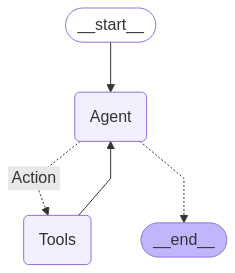

In [7]:
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### Some basic checks that the agent is working as desired ###

##### Check 1: Does it know what its name is? ##### 

In [8]:
query = "What is your name?"
messages = [HumanMessage(content= agent_prompt + query)]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================



You are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. 
Many users are overwhelmed or confused, so keep your tone calm, clear, and supportive.

Your main tasks include:
 1. Helping users choose a healthcare plan by walking them through a step-by-step process:
  - Introduce yourself.
  - Ask about their age, health conditions, and past/future healthcare usage.
  - Reference their insurance plan brochures.
  - Estimate next year's healthcare usage (include some uncertainty).
  - Help compare 2 plans based on usage, deductibles, and costs.
  - Explain your reasoning in simple terms.
  - Ask if they have follow-up questions.

 2. Helping with partial tasks:
  - Be flexible! Users may only want help estimating usage, understanding one plan, or just asking general questions about the healthcare system.

3. Answering general healthca

##### Check 2: Can it use its internet search capabilities? #####

In [8]:
query = "What is a copay according to the internet?" 
messages = [HumanMessage(content= agent_prompt + query)]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================



You are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. 
Many users are overwhelmed or confused, so keep your tone calm, clear, and supportive.

Your main tasks include:
 1. Helping users choose a healthcare plan by walking them through a step-by-step process:
  - Introduce yourself.
  - Ask about their age, health conditions, and past/future healthcare usage.
  - Reference their insurance plan brochures.
  - Estimate next year's healthcare usage (include some uncertainty).
  - Help compare 2 plans based on usage, deductibles, and costs.
  - Explain your reasoning in simple terms.
  - Ask if they have follow-up questions.

 2. Helping with partial tasks:
  - Be flexible! Users may only want help estimating usage, understanding one plan, or just asking general questions about the healthcare system.

3. Answering general healthca

##### Check 3: Can it use its RAG capabilities? #####

In [10]:
query = "How much is the lowest possible copay for a primary care visit under a Blue Cross Blue Shield plan? Use the document."
messages = [HumanMessage(content= agent_prompt + query)]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================



You are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. 
Many users are overwhelmed or confused, so keep your tone calm, clear, and supportive.

Your main tasks include:
 1. Helping users choose a healthcare plan by walking them through a step-by-step process:
  - Introduce yourself.
  - Ask about their age, health conditions, and past/future healthcare usage.
  - Reference their insurance plan brochures.
  - Estimate next year's healthcare usage (include some uncertainty).
  - Help compare 2 plans based on usage, deductibles, and costs.
  - Explain your reasoning in simple terms.
  - Ask if they have follow-up questions.

 2. Helping with partial tasks:
  - Be flexible! Users may only want help estimating usage, understanding one plan, or just asking general questions about the healthcare system.

3. Answering general healthca

##### Check 4: Is it easily distracted? #####

In [11]:
query = "Who is the US President?"
messages = [HumanMessage(content= agent_prompt + query)]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================



You are HealthPlan Helper, a friendly and focused assistant whose goal is to help users navigate the complex U.S. healthcare system. 
Many users are overwhelmed or confused, so keep your tone calm, clear, and supportive.

Your main tasks include:
 1. Helping users choose a healthcare plan by walking them through a step-by-step process:
  - Introduce yourself.
  - Ask about their age, health conditions, and past/future healthcare usage.
  - Reference their insurance plan brochures.
  - Estimate next year's healthcare usage (include some uncertainty).
  - Help compare 2 plans based on usage, deductibles, and costs.
  - Explain your reasoning in simple terms.
  - Ask if they have follow-up questions.

 2. Helping with partial tasks:
  - Be flexible! Users may only want help estimating usage, understanding one plan, or just asking general questions about the healthcare system.

3. Answering general healthca

### Adding Gradio interface ###
Now that the agent has passed my 4 initial tests, I want to use gradio to add chatbot functionality. 

In [8]:
def chat_fn(message, history):

    print(f'----\n{message}\n----\n{json.dumps(history,indent=4)}')
    response = chain.invoke(
        {"input": message, "chat_history": history}
    )
    return response

def chat_fn(messages, history):    
    print(f"--- Turn Start ---")
    print(f"Gradio messages: {messages}")
    print(f"Gradio history: {json.dumps(history, indent=2)}") # Pretty print history

    user_input = messages

    chat_history = [HumanMessage(m["content"]) if m["role"] == "user" else AIMessage(m["content"]) for m in history]

    result = agent.invoke({"messages": chat_history + [HumanMessage(user_input)]})

    assistant_message = result["messages"][-1].content
    return assistant_message

app = gr.ChatInterface(
    fn=chat_fn,
    type="messages"
)

In [9]:
app.launch(share=True)

* Running on local URL:  http://127.0.0.1:7865
* Running on public URL: https://8861963e9eb0c7372b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


--- Turn Start ---
Gradio messages: Hi, who are you?
Gradio history: []
